In [23]:
!pip install kagglehub

# Dataset Retriaval

In [20]:
import torch
import torch.nn
from PIL import Image
from torchvision import transforms
import os
import numpy as np
from torch.utils.data import Dataset



class custom_dataset(Dataset):
    def __init__(self, mode = "train", root = "datasets/split_data/", transforms = None):
        super().__init__()
        self.mode = mode
        self.root = root
        self.transforms = transforms

        #select split
        self.folder = os.path.join(self.root, self.mode)

        #initialize lists
        self.image_list = []
        self.label_list = []

        #save class lists
        self.class_list = os.listdir(self.folder)
        self.class_list.sort()

        for class_id in range(len(self.class_list)):
            for image in os.listdir(os.path.join(self.folder, self.class_list[class_id])):
                self.image_list.append(os.path.join(self.folder, self.class_list[class_id], image))
                label = np.zeros(len(self.class_list))
                label[class_id] = 1.0
                self.label_list.append(label)

    def __getitem__(self, index):
        image_name = self.image_list[index]
        label = self.label_list[index]


        image = Image.open(image_name)
        if(self.transforms):
            image = self.transforms(image)

        label = torch.tensor(label)

        return image, label

    def __len__(self):
        return len(self.image_list)


Number of images: 400
Sample data: (<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=384x384 at 0x2037599C590>, tensor([1., 0., 0., 0.], dtype=torch.float64))


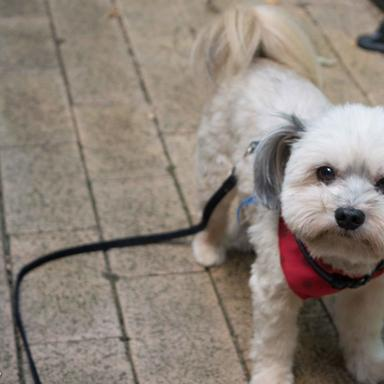

In [25]:
train_dataset = custom_dataset(mode="val", root="datasets/split_data")

# Print dataset size and sample data
print(f"Number of images: {len(train_dataset)}")
print(f"Sample data: {train_dataset[0]}")  # First image and its label
train_dataset[99][0]


# Building Resnet model

In [28]:
import torch
import torch.nn as nn
import torchvision.models as model


class ResnetBackboneModel(nn.Module):

    def __init__(self):
        super().__init__()

        self.resnet18 = model.resnet18(pretrained=True)
        self.resnet18 = torch.nn.Sequential(*(list(self.resnet18.children())[:-1]))
        for param in self.resnet18.parameters():
          param.requires_grad = False

        #num_ftrs = self.resnet18.fc.in_features
        

        self.classifier = torch.nn.Linear(512, 4)


    def forward(self, image):
        # Get predictions from ResNet18
        resnet_pred = self.resnet18(image).squeeze()
        out = self.classifier(resnet_pred)

        return out


In [29]:
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import SGD
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import ImageFolder
import tqdm
import os
from torchmetrics import F1Score
save_model_path = "checkpoints/"
pth_name = "saved_model.pth"

# Define the data augmentation pipeline
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomRotation(20),  # Random rotation between -20 and 20 degrees
    transforms.RandomResizedCrop(224),  # Random crop and resize to 224x224
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Random color jitter
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Resize([224, 224])  # Ensure consistent size
])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize([224, 224])  # Same size for validation images
])

def val(model, data_val, loss_function, writer, epoch, device):
    f1 = F1Score(num_classes=4, task='multiclass')
    data_iterator = enumerate(data_val)  # take batches
    f1_list = []
    f1t_list = []

    with torch.no_grad():
        model.eval()  # switch model to evaluation mode
        tq = tqdm.tqdm(total=len(data_val))
        tq.set_description('Validation:')

        total_loss = 0

        for _, batch in data_iterator:
            # forward propagation
            image, label = batch
            image = image.to(device)
            label = label.to(device)
            pred = model(image)

            loss = loss_function(pred, label)

            pred_labels = torch.argmax(pred, dim=1)
            # Use label directly as true_labels
            true_labels = label

            f1_list.extend(pred_labels.tolist())
            f1t_list.extend(true_labels.tolist())

            total_loss += loss.item()
            tq.update(1)

    f1score = f1(torch.tensor(f1_list), torch.tensor(f1t_list))
    writer.add_scalar("Validation F1", f1score, epoch)
    writer.add_scalar("Validation Loss", total_loss/len(data_val), epoch)

    tq.close()
    print("F1 score: ", f1score)

    return None


    return None

def train(model, train_loader, val_loader, optimizer, loss_fn, n_epochs, device):
    writer = SummaryWriter()

    model.to(device)  
    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0

        tq = tqdm.tqdm(total=len(train_loader))
        tq.set_description(f'Epoch {epoch+1}/{n_epochs}')

        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)

            # Compute loss
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()  # Reset the gradients of the optimizer
            # Backward pass
            loss.backward()

            # Update model parameters
            optimizer.step()

            running_loss += loss.item()
            tq.set_postfix(loss_st=f'{loss.item():.6f}')
            tq.update(1)

        writer.add_scalar("Training Loss", running_loss/len(train_loader), epoch)

        tq.close()
        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {running_loss/len(train_loader):.4f}')

        val(model, val_loader, loss_fn, writer, epoch, device)

        checkpoint = {
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
        }

        torch.save(checkpoint, os.path.join(save_model_path, pth_name))
        print(f"Saved the model to {save_model_path}")

def main():
    device = "cuda"
    
    # Apply transformations for training and validation datasets
    train_data = ImageFolder(root=r"datasets\split_data\train", transform=train_transforms)
    val_data = ImageFolder(root=r"datasets\split_data\val", transform=val_transforms)

    train_loader = DataLoader(
        train_data,
        batch_size=32,
        shuffle=True
    )

    val_loader = DataLoader(
        val_data,
        batch_size=16,
        drop_last=True
    )

    model = ResnetBackboneModel().to(device)
    optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)
    loss = nn.CrossEntropyLoss()

    max_epoch = 15

    train(model, train_loader, val_loader, optimizer, loss, max_epoch, device)

main()


c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)

KeyboardInterrupt



In [ ]:
!pip install torchmetrics

   ---------------------------------------- 0.0/926.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/926.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/926.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/926.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/926.4 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/926.4 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/926.4 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/926.4 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/926.4 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/926.4 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/926.4 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/926.4 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/926.4 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/926.4 kB ? 

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as model

class ResnetBackboneNotPretrained(nn.Module):

    def __init__(self):
        super().__init__()

        # Load ResNet18 without pretrained weights
        self.resnet18 = model.resnet18(pretrained=False)
        self.resnet18 = torch.nn.Sequential(*(list(self.resnet18.children())[:-1]))  


        # Classifier: a fully connected layer to map 512 features to 53 classes
        self.classifier = torch.nn.Linear(512, 4)

    def forward(self, image):
        # Pass the image through ResNet18 backbone
        
        resnet_pred = self.resnet18(image).squeeze()  # Remove the extra dimension

        # Pass through the classifier
        out = self.classifier(resnet_pred)

        return out


In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import SGD
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import ImageFolder
import tqdm
import os
from torchmetrics import F1Score
save_model_path = "checkpoints/"
pth_name = "not_pretrained.pth"

# Define the data augmentation pipeline
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomRotation(20),  # Random rotation between -20 and 20 degrees
    transforms.RandomResizedCrop(224),  # Random crop and resize to 224x224
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Resize([224, 224])  # Ensure consistent size
])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize([224, 224])  # Same size for validation images
])

def val(model, data_val, loss_function, writer, epoch, device):
    f1 = F1Score(num_classes=4, task='multiclass')
    data_iterator = enumerate(data_val)  # take batches
    f1_list = []
    f1t_list = []

    with torch.no_grad():
        model.eval()  # switch model to evaluation mode
        tq = tqdm.tqdm(total=len(data_val))
        tq.set_description('Validation:')

        total_loss = 0

        for _, batch in data_iterator:
            # forward propagation
            image, label = batch
            image = image.to(device)
            label = label.to(device)
            pred = model(image)

            loss = loss_function(pred, label)

            pred_labels = torch.argmax(pred, dim=1)
            # Use label directly as true_labels
            true_labels = label

            f1_list.extend(pred_labels.tolist())
            f1t_list.extend(true_labels.tolist())

            total_loss += loss.item()
            tq.update(1)

    f1score = f1(torch.tensor(f1_list), torch.tensor(f1t_list))
    writer.add_scalar("Validation F1", f1score, epoch)
    writer.add_scalar("Validation Loss", total_loss/len(data_val), epoch)

    tq.close()
    print("F1 score: ", f1score)

    return None


    return None

def train(model, train_loader, val_loader, optimizer, loss_fn, n_epochs, device):
    writer = SummaryWriter()

    model.to(device)  
    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0

        tq = tqdm.tqdm(total=len(train_loader))
        tq.set_description(f'Epoch {epoch+1}/{n_epochs}')

        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)

            # Compute loss
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()  # Reset the gradients of the optimizer
            # Backward pass
            loss.backward()

            # Update model parameters
            optimizer.step()

            running_loss += loss.item()
            tq.set_postfix(loss_st=f'{loss.item():.6f}')
            tq.update(1)

        writer.add_scalar("Training Loss", running_loss/len(train_loader), epoch)

        tq.close()
        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {running_loss/len(train_loader):.4f}')

        val(model, val_loader, loss_fn, writer, epoch, device)

        checkpoint = {
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
        }

        torch.save(checkpoint, os.path.join(save_model_path, pth_name))
        print(f"Saved the model to {save_model_path}")

def main():
    device = "cuda"
    
    # Apply transformations for training and validation datasets
    train_data = ImageFolder(root=r"datasets\split_data\train", transform=train_transforms)
    val_data = ImageFolder(root=r"datasets\split_data\val", transform=val_transforms)
    train_loader = DataLoader(
        train_data,
        batch_size=32,
        shuffle=True
    )

    val_loader = DataLoader(
        val_data,
        batch_size=16,
        drop_last=True
    )

    model = ResnetBackboneNotPretrained().to(device)
    optimizer = SGD(model.parameters(), lr=0.005)
    loss = nn.CrossEntropyLoss()

    max_epoch = 15

    train(model, train_loader, val_loader, optimizer, loss, max_epoch, device)

main()


In [ ]:
import torch
import torch.nn as nn
from torch.nn.functional import softmax
from torch.nn.functional import cross_entropy
from torchmetrics import F1Score
from torchvision import transforms

from torch.utils.data import DataLoader, Dataset
from torchvision.models import resnet18
from torchvision.models import vgg16
from datasets.dataset_retrieval import custom_dataset
from torch.optim import SGD, Adam
from torch.utils.tensorboard import SummaryWriter
import tqdm
from torchvision.datasets import ImageFolder
import os

save_model_path = "checkpoints/"


def val(model, data_val, loss_function, writer, epoch, device):
    f1score = 0
    f1 = F1Score(num_classes=47, task='multiclass')
    data_iterator = enumerate(data_val)  # Take batches
    f1_list = []
    f1t_list = []

    with torch.no_grad():
        model.eval()  # Switch model to evaluation mode
        tq = tqdm.tqdm(total=len(data_val))
        tq.set_description('Validation:')

        total_loss = 0

        for _, batch in data_iterator:
            # Forward propagation
            image, label = batch
            image = image.to(device)
            label = label.to(device).long()  # Convert labels to LongTensor
            
            pred = model(image)

            loss = loss_function(pred, label)

            pred = pred.softmax(dim=1)
            
            f1_list.extend(torch.argmax(pred, dim=1).tolist())
            f1t_list.extend(label.tolist())  # Labels are already in LongTensor format

            total_loss += loss.item()
            tq.update(1)

    f1score = f1(torch.tensor(f1_list), torch.tensor(f1t_list))
    writer.add_scalar("Validation F1", f1score, epoch)
    writer.add_scalar("Validation Loss", total_loss / len(data_val), epoch)

    tq.close()
    print("F1 score: ", f1score)

    return None


def train(model, train_loader, val_loader, optimizer, loss_fn, n_epochs, device, log_dir):
    # Scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
    writer = SummaryWriter(log_dir=os.path.join('runs', log_dir))

    model.to(device)  # Move the model to the specified device (e.g., GPU or CPU)
    model.train()  # Set the model to training mode

    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0

        tq = tqdm.tqdm(total=len(train_loader))
        tq.set_description('epoch %d' % epoch)

        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)  # Move the batch of images to the specified device
            labels = labels.to(device).long()  # Convert labels to LongTensor
            
            optimizer.zero_grad()  # Reset the gradients of the optimizer

            # Forward pass
            outputs = model(images)

            # Compute loss
            loss = loss_fn(outputs, labels)
            outputs = outputs.softmax(dim=1)

            # Backward pass
            loss.backward()

            # Update model parameters
            optimizer.step()
            # Scheduler.step()

            running_loss += loss.item()
            tq.set_postfix(loss_st='%.6f' % loss.item())
            tq.update(1)

        writer.add_scalar("Training Loss", running_loss / len(train_loader), epoch)

        tq.close()
        epoch_loss = running_loss / len(train_loader)
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, n_epochs, epoch_loss))

        # Check the performance of the model on the validation dataset
        val(model, val_loader, loss_fn, writer, epoch, device)

        # Save the model in .pth format
        checkpoint = {
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
        }

        torch.save(checkpoint, os.path.join(save_model_path, log_dir + '.pth'))
        print("Saved the model to " + save_model_path)




def main(model_name, optimizer_name, lr, pretrained, log_dir):
    
    device = "cuda"
    torch.cuda.set_per_process_memory_fraction(0.8, device=0)  # Limit GPU memory to 80%

    
    tr_train = transforms.Compose([
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomRotation(30),
        # transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
        transforms.Resize([250, 250]),
        transforms.RandomCrop(224),
        transforms.ToTensor(),

    ])
    
    tr_val = transforms.Compose([
        transforms.Resize([224, 224]),
        transforms.ToTensor(),

    ])

    train_data = ImageFolder(root=r"datasets\split_data\train", transform=tr_train)
    val_data = ImageFolder(root=r"datasets\split_data\val", transform=tr_val)

    train_loader = DataLoader(
        train_data,
        batch_size=8,
        shuffle=True,

    )

    val_loader = DataLoader(
        val_data,
        batch_size=8,
        drop_last=True,

    )
    
    max_epoch = 20

    if model_name=='resnet':
        model = resnet18(num_classes=4, pretrained=pretrained).to(device)
    elif model_name=='vgg':
        model = VGG16(num_classes=4, pretrained=pretrained).to(device)
    
    if optimizer_name=='sgd':
        optimizer = SGD(model.parameters(), lr=lr, momentum = 0.9)
    elif optimizer_name=='adam':
        optimizer = Adam(model.parameters(), lr=lr)
    
    loss = nn.CrossEntropyLoss()

    train(model, train_loader, val_loader, optimizer, loss, max_epoch, device, log_dir)
    
    
if __name__ == "__main__":
    
    main(model_name='resnet', optimizer_name='sgd', lr=1e-2, pretrained=False, log_dir='resnet_sgd')
    main(model_name='resnet', optimizer_name='adam', lr=1e-4, pretrained=False, log_dir='resnet_adam')
    
    main(model_name='resnet', optimizer_name='sgd', lr=1e-3, pretrained=True, log_dir='resnet_sgd_pretrained')
    main(model_name='resnet', optimizer_name='adam', lr=1e-4, pretrained=True, log_dir='resnet_adam_pretrained')


c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)













































































































































































































































































































































































































































Epoch [1/20], Loss: 1.6689












Validation:: 100%|██████████| 50/50 [00:01<00:00, 49.50it/s]


F1 score:  tensor(0.2600)
Saved the model to checkpoints/






















































































































































































































































































































































































































































































epoch 1: 100%|██████████| 350/350 [00:13<00:00, 25.59it/s, loss_st=1.484335]


Epoch [2/20], Loss: 1.4231













Validation:: 100%|██████████| 50/50 [00:01<00:00, 45.95it/s]


F1 score:  tensor(0.3325)
Saved the model to checkpoints/

















































































































































































































































































































































































































































































epoch 2: 100%|██████████| 350/350 [00:13<00:00, 26.39it/s, loss_st=1.536828]


Epoch [3/20], Loss: 1.3970












Validation:: 100%|██████████| 50/50 [00:01<00:00, 49.97it/s]


F1 score:  tensor(0.3075)
Saved the model to checkpoints/



















































































































































































































































































































































































































































































epoch 3: 100%|██████████| 350/350 [00:13<00:00, 26.24it/s, loss_st=1.225454]


Epoch [4/20], Loss: 1.3846












Validation:: 100%|██████████| 50/50 [00:01<00:00, 49.37it/s]


F1 score:  tensor(0.3350)
Saved the model to checkpoints/






















































































































































































































































































































































































































































































epoch 4: 100%|██████████| 350/350 [00:14<00:00, 24.63it/s, loss_st=1.494798]


Epoch [5/20], Loss: 1.3835













Validation:: 100%|██████████| 50/50 [00:01<00:00, 46.93it/s]


F1 score:  tensor(0.3350)
Saved the model to checkpoints/






















































































































































































































































































































































































































































































epoch 5: 100%|██████████| 350/350 [00:13<00:00, 25.39it/s, loss_st=1.053910]


Epoch [6/20], Loss: 1.3639












Validation:: 100%|██████████| 50/50 [00:01<00:00, 48.98it/s]


F1 score:  tensor(0.3575)
Saved the model to checkpoints/




















































































































































































































































































































































































































































































epoch 6: 100%|██████████| 350/350 [00:13<00:00, 25.97it/s, loss_st=1.340031]


Epoch [7/20], Loss: 1.3698














Validation:: 100%|██████████| 50/50 [00:01<00:00, 44.16it/s]


F1 score:  tensor(0.3400)
Saved the model to checkpoints/


























































































































































































































































































































































































































































































epoch 7: 100%|██████████| 350/350 [00:16<00:00, 21.21it/s, loss_st=1.489159]


Epoch [8/20], Loss: 1.3623
















Validation:: 100%|██████████| 50/50 [00:01<00:00, 31.91it/s]


F1 score:  tensor(0.3575)
Saved the model to checkpoints/


























































































































































































































































































































































































































































































epoch 8: 100%|██████████| 350/350 [00:16<00:00, 20.76it/s, loss_st=1.486912]


Epoch [9/20], Loss: 1.3706
















Validation:: 100%|██████████| 50/50 [00:01<00:00, 30.68it/s]


F1 score:  tensor(0.3425)
Saved the model to checkpoints/





































































































































































































































































































































































































































































































epoch 9: 100%|██████████| 350/350 [00:17<00:00, 20.14it/s, loss_st=1.385558]


Epoch [10/20], Loss: 1.3652













Validation:: 100%|██████████| 50/50 [00:01<00:00, 46.93it/s]


F1 score:  tensor(0.3700)
Saved the model to checkpoints/






















































































































































































































































































































































































































































































epoch 10: 100%|██████████| 350/350 [00:14<00:00, 23.65it/s, loss_st=1.649336]


Epoch [11/20], Loss: 1.3498














Validation:: 100%|██████████| 50/50 [00:01<00:00, 42.31it/s]


F1 score:  tensor(0.3475)
Saved the model to checkpoints/




















































































































































































































































































































































































































































































epoch 11: 100%|██████████| 350/350 [00:13<00:00, 25.66it/s, loss_st=1.237655]


Epoch [12/20], Loss: 1.3432












Validation:: 100%|██████████| 50/50 [00:01<00:00, 49.20it/s]


F1 score:  tensor(0.3475)
Saved the model to checkpoints/






















































































































































































































































































































































































































































































epoch 12: 100%|██████████| 350/350 [00:15<00:00, 23.32it/s, loss_st=1.466238]


Epoch [13/20], Loss: 1.3415














Validation:: 100%|██████████| 50/50 [00:01<00:00, 40.93it/s]


F1 score:  tensor(0.3825)
Saved the model to checkpoints/




















































































































































































































































































































































































































































































epoch 13: 100%|██████████| 350/350 [00:14<00:00, 24.97it/s, loss_st=1.023736]


Epoch [14/20], Loss: 1.3260












Validation:: 100%|██████████| 50/50 [00:01<00:00, 47.19it/s]


F1 score:  tensor(0.4375)
Saved the model to checkpoints/


















































































































































































































































































































































































































































































epoch 14: 100%|██████████| 350/350 [00:13<00:00, 26.79it/s, loss_st=1.258380]


Epoch [15/20], Loss: 1.2880












Validation:: 100%|██████████| 50/50 [00:00<00:00, 51.39it/s]


F1 score:  tensor(0.4000)
Saved the model to checkpoints/



















































































































































































































































































































































































































































































epoch 15: 100%|██████████| 350/350 [00:13<00:00, 26.33it/s, loss_st=1.825341]


Epoch [16/20], Loss: 1.2510












Validation:: 100%|██████████| 50/50 [00:01<00:00, 49.23it/s]


F1 score:  tensor(0.4300)
Saved the model to checkpoints/




















































































































































































































































































































































































































































































epoch 16: 100%|██████████| 350/350 [00:13<00:00, 25.53it/s, loss_st=1.163150]


Epoch [17/20], Loss: 1.2233













Validation:: 100%|██████████| 50/50 [00:01<00:00, 46.72it/s]


F1 score:  tensor(0.4450)
Saved the model to checkpoints/




















































































































































































































































































































































































































































































epoch 17: 100%|██████████| 350/350 [00:13<00:00, 25.54it/s, loss_st=1.085029]


Epoch [18/20], Loss: 1.1993














Validation:: 100%|██████████| 50/50 [00:01<00:00, 38.48it/s]


F1 score:  tensor(0.4750)
Saved the model to checkpoints/






















































































































































































































































































































































































































































































epoch 18: 100%|██████████| 350/350 [00:14<00:00, 23.48it/s, loss_st=1.029635]


Epoch [19/20], Loss: 1.1804












Validation:: 100%|██████████| 50/50 [00:01<00:00, 47.66it/s]


F1 score:  tensor(0.4975)
Saved the model to checkpoints/



















































































































































































































































































































































































































































































epoch 19: 100%|██████████| 350/350 [00:13<00:00, 25.47it/s, loss_st=1.379625]


Epoch [20/20], Loss: 1.1552













Validation:: 100%|██████████| 50/50 [00:01<00:00, 48.15it/s]


F1 score:  tensor(0.5350)
Saved the model to checkpoints/





















































































































































































































































































































































































































































































epoch 0: 100%|██████████| 350/350 [00:13<00:00, 25.59it/s, loss_st=1.327640]


Epoch [1/20], Loss: 1.4066












Validation:: 100%|██████████| 50/50 [00:00<00:00, 50.30it/s]


F1 score:  tensor(0.3100)
Saved the model to checkpoints/






















































































































































































































































































































































































































































































epoch 1: 100%|██████████| 350/350 [00:13<00:00, 25.51it/s, loss_st=1.298070]


Epoch [2/20], Loss: 1.3685












Validation:: 100%|██████████| 50/50 [00:00<00:00, 50.45it/s]


F1 score:  tensor(0.3500)
Saved the model to checkpoints/






















































































































































































































































































































































































































































































epoch 2: 100%|██████████| 350/350 [00:14<00:00, 24.80it/s, loss_st=1.328975]


Epoch [3/20], Loss: 1.3151












Validation:: 100%|██████████| 50/50 [00:00<00:00, 50.03it/s]


F1 score:  tensor(0.4225)
Saved the model to checkpoints/





















































































































































































































































































































































































































































































epoch 3: 100%|██████████| 350/350 [00:13<00:00, 25.55it/s, loss_st=1.230326]


Epoch [4/20], Loss: 1.2501












Validation:: 100%|██████████| 50/50 [00:01<00:00, 49.13it/s]


F1 score:  tensor(0.4400)
Saved the model to checkpoints/






















































































































































































































































































































































































































































































epoch 4: 100%|██████████| 350/350 [00:13<00:00, 25.56it/s, loss_st=1.452996]


Epoch [5/20], Loss: 1.1845













Validation:: 100%|██████████| 50/50 [00:01<00:00, 48.29it/s]


F1 score:  tensor(0.5825)
Saved the model to checkpoints/





















































































































































































































































































































































































































































































epoch 5: 100%|██████████| 350/350 [00:13<00:00, 25.81it/s, loss_st=0.811847]


Epoch [6/20], Loss: 1.1007













Validation:: 100%|██████████| 50/50 [00:01<00:00, 46.91it/s]


F1 score:  tensor(0.5025)
Saved the model to checkpoints/






















































































































































































































































































































































































































































































epoch 6: 100%|██████████| 350/350 [00:13<00:00, 25.93it/s, loss_st=1.456034]


Epoch [7/20], Loss: 1.0633












Validation:: 100%|██████████| 50/50 [00:00<00:00, 50.58it/s]


F1 score:  tensor(0.5625)
Saved the model to checkpoints/






















































































































































































































































































































































































































































































epoch 7: 100%|██████████| 350/350 [00:13<00:00, 25.04it/s, loss_st=0.694880]


Epoch [8/20], Loss: 1.0481













Validation:: 100%|██████████| 50/50 [00:01<00:00, 48.43it/s]


F1 score:  tensor(0.5975)
Saved the model to checkpoints/





















































































































































































































































































































































































































































































epoch 8: 100%|██████████| 350/350 [00:13<00:00, 25.65it/s, loss_st=1.551662]


Epoch [9/20], Loss: 1.0094












Validation:: 100%|██████████| 50/50 [00:01<00:00, 49.32it/s]


F1 score:  tensor(0.5275)
Saved the model to checkpoints/






















































































































































































































































































































































































































































































epoch 9: 100%|██████████| 350/350 [00:13<00:00, 25.88it/s, loss_st=1.155037]


Epoch [10/20], Loss: 0.9633













Validation:: 100%|██████████| 50/50 [00:01<00:00, 46.79it/s]


F1 score:  tensor(0.6150)
Saved the model to checkpoints/





















































































































































































































































































































































































































































































epoch 10: 100%|██████████| 350/350 [00:13<00:00, 25.78it/s, loss_st=1.119025]


Epoch [11/20], Loss: 0.9412












Validation:: 100%|██████████| 50/50 [00:00<00:00, 50.33it/s]


F1 score:  tensor(0.6275)
Saved the model to checkpoints/





















































































































































































































































































































































































































































































epoch 11: 100%|██████████| 350/350 [00:13<00:00, 25.72it/s, loss_st=1.195078]


Epoch [12/20], Loss: 0.9262












Validation:: 100%|██████████| 50/50 [00:00<00:00, 50.64it/s]


F1 score:  tensor(0.5875)
Saved the model to checkpoints/





















































































































































































































































































































































































































































































epoch 12: 100%|██████████| 350/350 [00:13<00:00, 25.81it/s, loss_st=1.141948]


Epoch [13/20], Loss: 0.8922












Validation:: 100%|██████████| 50/50 [00:01<00:00, 48.19it/s]


F1 score:  tensor(0.6050)
Saved the model to checkpoints/





















































































































































































































































































































































































































































































epoch 13: 100%|██████████| 350/350 [00:13<00:00, 25.59it/s, loss_st=1.620439]


Epoch [14/20], Loss: 0.8869












Validation:: 100%|██████████| 50/50 [00:00<00:00, 50.64it/s]


F1 score:  tensor(0.6125)
Saved the model to checkpoints/





















































































































































































































































































































































































































































































epoch 14: 100%|██████████| 350/350 [00:13<00:00, 25.68it/s, loss_st=0.950499]


Epoch [15/20], Loss: 0.8492












Validation:: 100%|██████████| 50/50 [00:00<00:00, 51.40it/s]


F1 score:  tensor(0.6550)
Saved the model to checkpoints/





















































































































































































































































































































































































































































































epoch 15: 100%|██████████| 350/350 [00:13<00:00, 25.84it/s, loss_st=1.332285]


Epoch [16/20], Loss: 0.8267












Validation:: 100%|██████████| 50/50 [00:00<00:00, 51.18it/s]


F1 score:  tensor(0.5600)
Saved the model to checkpoints/






















































































































































































































































































































































































































































































epoch 16: 100%|██████████| 350/350 [00:13<00:00, 25.45it/s, loss_st=0.772703]


Epoch [17/20], Loss: 0.8045












Validation:: 100%|██████████| 50/50 [00:01<00:00, 50.00it/s]


F1 score:  tensor(0.6125)
Saved the model to checkpoints/






















































































































































































































































































































































































































































































epoch 17: 100%|██████████| 350/350 [00:13<00:00, 25.68it/s, loss_st=0.590173]


Epoch [18/20], Loss: 0.7919












Validation:: 100%|██████████| 50/50 [00:01<00:00, 49.61it/s]


F1 score:  tensor(0.6800)
Saved the model to checkpoints/






















































































































































































































































































































































































































































































epoch 18: 100%|██████████| 350/350 [00:13<00:00, 25.56it/s, loss_st=1.406005]


Epoch [19/20], Loss: 0.7709












Validation:: 100%|██████████| 50/50 [00:01<00:00, 49.70it/s]


F1 score:  tensor(0.6925)
Saved the model to checkpoints/
























































































































































































































































































































































































































































































epoch 19: 100%|██████████| 350/350 [00:15<00:00, 22.54it/s, loss_st=1.045516]


Epoch [20/20], Loss: 0.7709















Validation:: 100%|██████████| 50/50 [00:01<00:00, 37.03it/s]
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


F1 score:  tensor(0.6400)
Saved the model to checkpoints/


ValueError: The parameter 'num_classes' expected value 1000 but got 4 instead.

# Just analyusing data and labels after augmentation

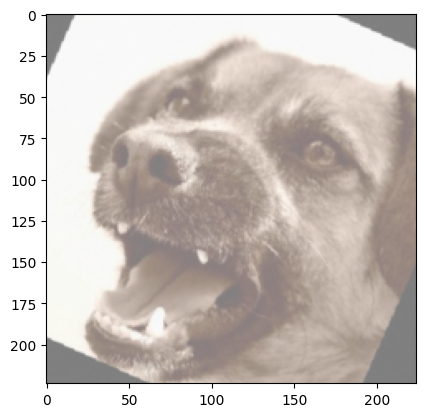

Label: 0


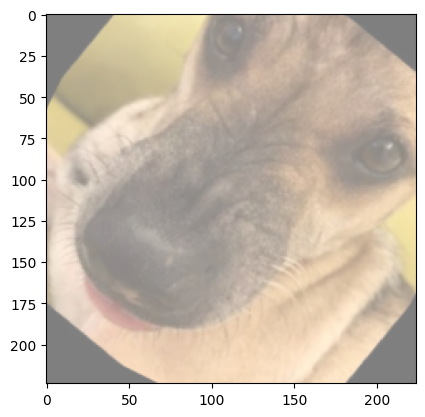

Label: 0


In [11]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Helper function to unnormalize the image (if you used normalization in transforms)
def imshow(img):
    # Unnormalize the image if normalization was applied (this is just an example)
    img = img / 2 + 0.5  # Denormalize the image (for example if the mean=0, std=1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Convert CHW to HWC for display
    plt.show()

# Loop through the dataset and display images
for i, (images, labels) in enumerate(train_data):
    if i < 2:  # Just displaying the first 2 images
        imshow(images)  # Show the image
        print("Label:", labels)  # Print the label


In [ ]:
import torch
import torch.nn as nn
from torch.nn.functional import softmax
from torch.nn.functional import cross_entropy
from torchmetrics import F1Score
from torchvision import transforms

from torch.utils.data import DataLoader, Dataset
from torchvision.models import resnet18
from torchvision.models import vgg16
from datasets.dataset_retrieval import custom_dataset
from torch.optim import SGD, Adam
from torch.utils.tensorboard import SummaryWriter
import tqdm
from torchvision.datasets import ImageFolder
import os

save_model_path = "checkpoints/"


def val(model, data_val, loss_function, writer, epoch, device):
    f1score = 0
    f1 = F1Score(num_classes=47, task='multiclass')
    data_iterator = enumerate(data_val)  # Take batches
    f1_list = []
    f1t_list = []

    with torch.no_grad():
        model.eval()  # Switch model to evaluation mode
        tq = tqdm.tqdm(total=len(data_val))
        tq.set_description('Validation:')

        total_loss = 0

        for _, batch in data_iterator:
            # Forward propagation
            image, label = batch
            image = image.to(device)
            label = label.to(device).long()  # Convert labels to LongTensor
            
            pred = model(image)

            loss = loss_function(pred, label)

            pred = pred.softmax(dim=1)
            
            f1_list.extend(torch.argmax(pred, dim=1).tolist())
            f1t_list.extend(label.tolist())  # Labels are already in LongTensor format

            total_loss += loss.item()
            tq.update(1)

    f1score = f1(torch.tensor(f1_list), torch.tensor(f1t_list))
    writer.add_scalar("Validation F1", f1score, epoch)
    writer.add_scalar("Validation Loss", total_loss / len(data_val), epoch)

    tq.close()
    print("F1 score: ", f1score)

    return None


def train(model, train_loader, val_loader, optimizer, loss_fn, n_epochs, device, log_dir):
    # Scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
    writer = SummaryWriter(log_dir=os.path.join('runs', log_dir))

    model.to(device)  # Move the model to the specified device (e.g., GPU or CPU)
    model.train()  # Set the model to training mode

    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0

        tq = tqdm.tqdm(total=len(train_loader))
        tq.set_description('epoch %d' % epoch)

        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)  # Move the batch of images to the specified device
            labels = labels.to(device).long()  # Convert labels to LongTensor
            
            optimizer.zero_grad()  # Reset the gradients of the optimizer

            # Forward pass
            outputs = model(images)

            # Compute loss
            loss = loss_fn(outputs, labels)
            outputs = outputs.softmax(dim=1)

            # Backward pass
            loss.backward()

            # Update model parameters
            optimizer.step()
            # Scheduler.step()

            running_loss += loss.item()
            tq.set_postfix(loss_st='%.6f' % loss.item())
            tq.update(1)

        writer.add_scalar("Training Loss", running_loss / len(train_loader), epoch)

        tq.close()
        epoch_loss = running_loss / len(train_loader)
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, n_epochs, epoch_loss))

        # Check the performance of the model on the validation dataset
        val(model, val_loader, loss_fn, writer, epoch, device)

        # Save the model in .pth format
        checkpoint = {
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
        }

        torch.save(checkpoint, os.path.join(save_model_path, log_dir + '.pth'))
        print("Saved the model to " + save_model_path)




def main(model_name, optimizer_name, lr, pretrained, log_dir):
    
    device = "cuda"
    torch.cuda.set_per_process_memory_fraction(0.8, device=0)  # Limit GPU memory to 80%

    
    tr_train = transforms.Compose([
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomRotation(30),
        # transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
        transforms.Resize([250, 250]),
        transforms.RandomCrop(224),
        transforms.ToTensor(),

    ])
    
    tr_val = transforms.Compose([
        transforms.Resize([224, 224]),
        transforms.ToTensor(),

    ])

    train_data = ImageFolder(root=r"datasets\split_data\train", transform=tr_train)
    val_data = ImageFolder(root=r"datasets\split_data\val", transform=tr_val)

    train_loader = DataLoader(
        train_data,
        batch_size=8,
        shuffle=True,

    )

    val_loader = DataLoader(
        val_data,
        batch_size=8,
        drop_last=True,

    )
    
    max_epoch = 20

    if model_name=='resnet':
        model = resnet18(pretrained=pretrained).to(device)
        model.fc = nn.Linear(model.fc.in_features, 4)
        model.to(device)
    elif model_name=='vgg':
        model = VGG16(num_classes=4, pretrained=pretrained).to(device)

    
    if optimizer_name=='sgd':
        optimizer = SGD(model.parameters(), lr=lr, momentum = 0.9)
    elif optimizer_name=='adam':
        optimizer = Adam(model.parameters(), lr=lr)

    
    
    loss = nn.CrossEntropyLoss()

    train(model, train_loader, val_loader, optimizer, loss, max_epoch, device, log_dir)
    
    
if __name__ == "__main__":

    
    main(model_name='resnet', optimizer_name='sgd', lr=1e-3, pretrained=True, log_dir='resnet_sgd_pretrained')
    main(model_name='resnet', optimizer_name='adam', lr=1e-4, pretrained=True, log_dir='resnet_adam_pretrained')
    





















































































































































































































































































































































































































































































epoch 0: 100%|██████████| 350/350 [00:13<00:00, 25.56it/s, loss_st=0.622823]


Epoch [1/20], Loss: 1.0203













Validation:: 100%|██████████| 50/50 [00:01<00:00, 48.76it/s]


F1 score:  tensor(0.8000)
Saved the model to checkpoints/






















































































































































































































































































































































































































































































epoch 1: 100%|██████████| 350/350 [00:13<00:00, 25.83it/s, loss_st=0.710972]


Epoch [2/20], Loss: 0.6798












Validation:: 100%|██████████| 50/50 [00:01<00:00, 49.32it/s]


F1 score:  tensor(0.7750)
Saved the model to checkpoints/




















































































































































































































































































































































































































































































epoch 2: 100%|██████████| 350/350 [00:13<00:00, 26.59it/s, loss_st=0.495702]


Epoch [3/20], Loss: 0.5972













Validation:: 100%|██████████| 50/50 [00:01<00:00, 44.82it/s]


F1 score:  tensor(0.8050)
Saved the model to checkpoints/




















































































































































































































































































































































































































































































epoch 3: 100%|██████████| 350/350 [00:13<00:00, 26.19it/s, loss_st=1.015938]


Epoch [4/20], Loss: 0.5430












Validation:: 100%|██████████| 50/50 [00:01<00:00, 48.14it/s]


F1 score:  tensor(0.8050)
Saved the model to checkpoints/





















































































































































































































































































































































































































































































epoch 4: 100%|██████████| 350/350 [00:13<00:00, 25.82it/s, loss_st=0.509981]


Epoch [5/20], Loss: 0.4791













Validation:: 100%|██████████| 50/50 [00:01<00:00, 47.08it/s]


F1 score:  tensor(0.8200)
Saved the model to checkpoints/





















































































































































































































































































































































































































































































epoch 5: 100%|██████████| 350/350 [00:13<00:00, 25.71it/s, loss_st=0.766110]


Epoch [6/20], Loss: 0.3984














Validation:: 100%|██████████| 50/50 [00:01<00:00, 43.20it/s]


F1 score:  tensor(0.8550)
Saved the model to checkpoints/






















































































































































































































































































































































































































































































epoch 6: 100%|██████████| 350/350 [00:14<00:00, 24.22it/s, loss_st=0.072637]


Epoch [7/20], Loss: 0.3718














Validation:: 100%|██████████| 50/50 [00:01<00:00, 40.11it/s]


F1 score:  tensor(0.8325)
Saved the model to checkpoints/





















































































































































































































































































































































































































































































epoch 7: 100%|██████████| 350/350 [00:14<00:00, 24.82it/s, loss_st=0.581828]


Epoch [8/20], Loss: 0.3104













Validation:: 100%|██████████| 50/50 [00:01<00:00, 42.95it/s]


F1 score:  tensor(0.8300)
Saved the model to checkpoints/






















































































































































































































































































































































































































































































epoch 8: 100%|██████████| 350/350 [00:14<00:00, 24.90it/s, loss_st=0.245375]


Epoch [9/20], Loss: 0.2821













Validation:: 100%|██████████| 50/50 [00:01<00:00, 46.64it/s]


F1 score:  tensor(0.8075)
Saved the model to checkpoints/






















































































































































































































































































































































































































































































epoch 9: 100%|██████████| 350/350 [00:13<00:00, 25.14it/s, loss_st=0.245596]


Epoch [10/20], Loss: 0.2630













Validation:: 100%|██████████| 50/50 [00:01<00:00, 47.72it/s]


F1 score:  tensor(0.8750)
Saved the model to checkpoints/


















































































































































































































































































































































































































































































epoch 10: 100%|██████████| 350/350 [00:13<00:00, 26.11it/s, loss_st=0.118167]


Epoch [11/20], Loss: 0.2669












Validation:: 100%|██████████| 50/50 [00:01<00:00, 49.16it/s]


F1 score:  tensor(0.8475)
Saved the model to checkpoints/




















































































































































































































































































































































































































































































epoch 11: 100%|██████████| 350/350 [00:13<00:00, 26.22it/s, loss_st=0.052601]


Epoch [12/20], Loss: 0.2293













Validation:: 100%|██████████| 50/50 [00:01<00:00, 47.91it/s]


F1 score:  tensor(0.8600)
Saved the model to checkpoints/




















































































































































































































































































































































































































































































epoch 12: 100%|██████████| 350/350 [00:13<00:00, 25.37it/s, loss_st=0.002273]


Epoch [13/20], Loss: 0.2378















Validation:: 100%|██████████| 50/50 [00:01<00:00, 36.94it/s]


F1 score:  tensor(0.8475)
Saved the model to checkpoints/



















































































































































































































































































































































































































































































epoch 13: 100%|██████████| 350/350 [00:13<00:00, 26.27it/s, loss_st=0.010165]


Epoch [14/20], Loss: 0.2015













Validation:: 100%|██████████| 50/50 [00:01<00:00, 47.22it/s]


F1 score:  tensor(0.8750)
Saved the model to checkpoints/


















































































































































































































































































































































































































































































epoch 14: 100%|██████████| 350/350 [00:13<00:00, 26.33it/s, loss_st=2.597157]


Epoch [15/20], Loss: 0.2151













Validation:: 100%|██████████| 50/50 [00:01<00:00, 48.17it/s]


F1 score:  tensor(0.8625)
Saved the model to checkpoints/


















































































































































































































































































































































































































































































epoch 15: 100%|██████████| 350/350 [00:13<00:00, 26.43it/s, loss_st=0.013831]


Epoch [16/20], Loss: 0.1862












Validation:: 100%|██████████| 50/50 [00:01<00:00, 48.57it/s]


F1 score:  tensor(0.8425)
Saved the model to checkpoints/




















































































































































































































































































































































































































































































epoch 16: 100%|██████████| 350/350 [00:13<00:00, 26.23it/s, loss_st=0.019809]


Epoch [17/20], Loss: 0.1783












Validation:: 100%|██████████| 50/50 [00:01<00:00, 48.62it/s]


F1 score:  tensor(0.8650)
Saved the model to checkpoints/


















































































































































































































































































































































































































































































epoch 17: 100%|██████████| 350/350 [00:13<00:00, 26.33it/s, loss_st=0.012568]


Epoch [18/20], Loss: 0.2036













Validation:: 100%|██████████| 50/50 [00:01<00:00, 48.38it/s]


F1 score:  tensor(0.8275)
Saved the model to checkpoints/




















































































































































































































































































































































































































































































epoch 18: 100%|██████████| 350/350 [00:13<00:00, 26.32it/s, loss_st=0.568849]


Epoch [19/20], Loss: 0.1605













Validation:: 100%|██████████| 50/50 [00:01<00:00, 48.14it/s]


F1 score:  tensor(0.8525)
Saved the model to checkpoints/




















































































































































































































































































































































































































































































epoch 19: 100%|██████████| 350/350 [00:13<00:00, 26.44it/s, loss_st=0.005429]


Epoch [20/20], Loss: 0.1467













Validation:: 100%|██████████| 50/50 [00:01<00:00, 47.79it/s]


F1 score:  tensor(0.8675)
Saved the model to checkpoints/






















































































































































































































































































































































































































































































epoch 0: 100%|██████████| 350/350 [00:13<00:00, 25.45it/s, loss_st=1.214557]


Epoch [1/20], Loss: 0.8405













Validation:: 100%|██████████| 50/50 [00:01<00:00, 45.98it/s]


F1 score:  tensor(0.8025)
Saved the model to checkpoints/






















































































































































































































































































































































































































































































epoch 1: 100%|██████████| 350/350 [00:13<00:00, 25.40it/s, loss_st=0.796705]


Epoch [2/20], Loss: 0.5903













Validation:: 100%|██████████| 50/50 [00:01<00:00, 46.50it/s]


F1 score:  tensor(0.8075)
Saved the model to checkpoints/





















































































































































































































































































































































































































































































epoch 2: 100%|██████████| 350/350 [00:14<00:00, 23.97it/s, loss_st=1.049985]


Epoch [3/20], Loss: 0.4923













Validation:: 100%|██████████| 50/50 [00:01<00:00, 47.30it/s]


F1 score:  tensor(0.8300)
Saved the model to checkpoints/





















































































































































































































































































































































































































































































epoch 3: 100%|██████████| 350/350 [00:13<00:00, 25.41it/s, loss_st=0.655565]


Epoch [4/20], Loss: 0.4202












Validation:: 100%|██████████| 50/50 [00:01<00:00, 49.53it/s]


F1 score:  tensor(0.8050)
Saved the model to checkpoints/





















































































































































































































































































































































































































































































epoch 4: 100%|██████████| 350/350 [00:13<00:00, 25.86it/s, loss_st=2.070728]


Epoch [5/20], Loss: 0.3661












Validation:: 100%|██████████| 50/50 [00:01<00:00, 49.05it/s]


F1 score:  tensor(0.8425)
Saved the model to checkpoints/






















































































































































































































































































































































































































































































epoch 5: 100%|██████████| 350/350 [00:13<00:00, 25.94it/s, loss_st=0.057561]


Epoch [6/20], Loss: 0.3081












Validation:: 100%|██████████| 50/50 [00:01<00:00, 46.28it/s]


F1 score:  tensor(0.8675)
Saved the model to checkpoints/





















































































































































































































































































































































































































































































epoch 6: 100%|██████████| 350/350 [00:13<00:00, 26.11it/s, loss_st=1.613731]


Epoch [7/20], Loss: 0.2750












Validation:: 100%|██████████| 50/50 [00:01<00:00, 49.48it/s]


F1 score:  tensor(0.8325)
Saved the model to checkpoints/





















































































































































































































































































































































































































































































epoch 7: 100%|██████████| 350/350 [00:13<00:00, 25.98it/s, loss_st=0.049061]


Epoch [8/20], Loss: 0.2467












Validation:: 100%|██████████| 50/50 [00:00<00:00, 51.39it/s]


F1 score:  tensor(0.8300)
Saved the model to checkpoints/





















































































































































































































































































































































































































































































epoch 8: 100%|██████████| 350/350 [00:13<00:00, 25.83it/s, loss_st=1.736734]


Epoch [9/20], Loss: 0.2418












Validation:: 100%|██████████| 50/50 [00:01<00:00, 49.95it/s]


F1 score:  tensor(0.8225)
Saved the model to checkpoints/























































































































































































































































































































































































































































































epoch 9: 100%|██████████| 350/350 [00:14<00:00, 23.96it/s, loss_st=0.134148]


Epoch [10/20], Loss: 0.2471














Validation:: 100%|██████████| 50/50 [00:01<00:00, 43.64it/s]


F1 score:  tensor(0.8650)
Saved the model to checkpoints/























































































































































































































































































































































































































































































epoch 10: 100%|██████████| 350/350 [00:15<00:00, 22.00it/s, loss_st=0.020546]


Epoch [11/20], Loss: 0.1570













Validation:: 100%|██████████| 50/50 [00:01<00:00, 46.90it/s]


F1 score:  tensor(0.8275)
Saved the model to checkpoints/






















































































































































































































































































































































































































































































epoch 11: 100%|██████████| 350/350 [00:14<00:00, 24.03it/s, loss_st=0.711372]


Epoch [12/20], Loss: 0.1840














Validation:: 100%|██████████| 50/50 [00:01<00:00, 44.28it/s]


F1 score:  tensor(0.8350)
Saved the model to checkpoints/






















































































































































































































































































































































































































































































epoch 12: 100%|██████████| 350/350 [00:14<00:00, 24.20it/s, loss_st=0.165802]


Epoch [13/20], Loss: 0.1817












Validation:: 100%|██████████| 50/50 [00:01<00:00, 47.45it/s]


F1 score:  tensor(0.8250)
Saved the model to checkpoints/






















































































































































































































































































































































































































































































epoch 13: 100%|██████████| 350/350 [00:13<00:00, 25.47it/s, loss_st=0.037713]


Epoch [14/20], Loss: 0.1774













Validation:: 100%|██████████| 50/50 [00:01<00:00, 44.61it/s]


F1 score:  tensor(0.8400)
Saved the model to checkpoints/






















































































































































































































































































































































































































































































epoch 14: 100%|██████████| 350/350 [00:13<00:00, 25.55it/s, loss_st=0.079170]


Epoch [15/20], Loss: 0.1734












Validation:: 100%|██████████| 50/50 [00:01<00:00, 48.71it/s]


F1 score:  tensor(0.8400)
Saved the model to checkpoints/






















































































































































































































































































































































































































































































epoch 15: 100%|██████████| 350/350 [00:13<00:00, 25.18it/s, loss_st=0.014619]


Epoch [16/20], Loss: 0.1328












Validation:: 100%|██████████| 50/50 [00:01<00:00, 48.83it/s]


F1 score:  tensor(0.8325)
Saved the model to checkpoints/























































































































































































































































































































































































































































































epoch 16: 100%|██████████| 350/350 [00:15<00:00, 23.11it/s, loss_st=0.734622]


Epoch [17/20], Loss: 0.1520
















Validation:: 100%|██████████| 50/50 [00:01<00:00, 36.66it/s]


F1 score:  tensor(0.8550)
Saved the model to checkpoints/
































































































































































































































































































































































































































































































epoch 17: 100%|██████████| 350/350 [00:17<00:00, 20.22it/s, loss_st=0.030375]


Epoch [18/20], Loss: 0.1325
















Validation:: 100%|██████████| 50/50 [00:01<00:00, 36.01it/s]


F1 score:  tensor(0.8600)
Saved the model to checkpoints/


























































































































































































































































































































































































































































































epoch 18: 100%|██████████| 350/350 [00:16<00:00, 20.89it/s, loss_st=0.078139]


Epoch [19/20], Loss: 0.1272
















Validation:: 100%|██████████| 50/50 [00:01<00:00, 35.77it/s]


F1 score:  tensor(0.8450)
Saved the model to checkpoints/



































































































































































































































































































































































































































































































epoch 19: 100%|██████████| 350/350 [00:17<00:00, 20.19it/s, loss_st=1.428206]


Epoch [20/20], Loss: 0.1290














Validation:: 100%|██████████| 50/50 [00:01<00:00, 40.57it/s]


F1 score:  tensor(0.8400)
Saved the model to checkpoints/


# Performance of the model on the test set

In [26]:
import torch
from torchvision.models import resnet18
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from tqdm import tqdm

# Function to load the model from a checkpoint
def load_model(checkpoint_path, num_classes, device):
    model = resnet18(pretrained=False)  # Initialize ResNet-18 model
    model.fc = torch.nn.Linear(model.fc.in_features, num_classes)  # Adjust for the number of classes

    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['state_dict'])
    model.to(device)
    model.eval()
    print(f"Model loaded successfully from {checkpoint_path}")
    return model

# Function to prepare the test dataset
def prepare_test_data(test_data_path, batch_size):
    tr_test = transforms.Compose([
        transforms.Resize([224, 224]),  # Resize images
        transforms.ToTensor(),  # Convert to tensor
    ])

    # Load the test dataset
    test_data = ImageFolder(root=test_data_path, transform=tr_test)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)  # No need to shuffle for testing
    print(f"Test dataset size: {len(test_data)} samples")
    return test_loader

# Function to evaluate accuracy on the test dataset
def evaluate_accuracy(model, test_loader, device):
    correct_preds = 0
    total_preds = 0

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images = images.to(device)
            labels = labels.to(device).long()

            # Forward pass
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)  # Get the predicted class

            # Update counts
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)

    accuracy = correct_preds / total_preds
    return accuracy

# Main script
if __name__ == "__main__":
    # Settings
    checkpoint_paths = [
        "checkpoints/resnet_adam.pth",
        "checkpoints/resnet_adam_pretrained.pth",
        "checkpoints/resnet_sgd.pth",
        "checkpoints/resnet_sgd_pretrained.pth",
    ]  # List all checkpoint paths
    test_data_path = "datasets/split_data/test"  # Path to your test dataset
    batch_size = 8  # Batch size for testing
    device = "cuda" if torch.cuda.is_available() else "cpu"
    num_classes = 4  # Number of output classes

    # Prepare the test data
    test_loader = prepare_test_data(test_data_path, batch_size)

    # Loop through checkpoints and evaluate accuracy
    for checkpoint_path in checkpoint_paths:
        model = load_model(checkpoint_path, num_classes, device)
        test_accuracy = evaluate_accuracy(model, test_loader, device)
        print(f"Accuracy for {checkpoint_path.split('/')[-1]}: {test_accuracy:.4f}")


Test dataset size: 804 samples


c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_20380\717047152.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by t

Model loaded successfully from checkpoints/resnet_adam.pth

























Testing: 100%|██████████| 101/101 [00:02<00:00, 40.08it/s]


Accuracy for resnet_adam.pth: 0.6642
Model loaded successfully from checkpoints/resnet_adam_pretrained.pth
























Testing: 100%|██████████| 101/101 [00:02<00:00, 39.42it/s]


Accuracy for resnet_adam_pretrained.pth: 0.8060
Model loaded successfully from checkpoints/resnet_sgd.pth


























Testing: 100%|██████████| 101/101 [00:02<00:00, 38.21it/s]


Accuracy for resnet_sgd.pth: 0.5498
Model loaded successfully from checkpoints/resnet_sgd_pretrained.pth



























Testing: 100%|██████████| 101/101 [00:02<00:00, 37.15it/s]

Accuracy for resnet_sgd_pretrained.pth: 0.8371
